In [92]:
# Import libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings


In [93]:
from pathlib import Path
import pandas as pd

def find_project_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists():
            return p
    return start  # fallback

PROJECT_ROOT = find_project_root()
DATA_PATH = PROJECT_ROOT / "data" / "raw" / "stud.csv"

In [94]:
df = pd.read_csv(DATA_PATH)
print(df.head())
print(df.shape)
print(df.columns)

   gender race_ethnicity parental_level_of_education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test_preparation_course  math_score  reading_score  writing_score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  
(1000, 8)
Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course', 'math_score', 'reading_score',
       'w

# Preprocessing

In [95]:
TARGET = "math_score"

# Predicting math_score without reading_score and writing_score
# otherwise these features will dominate the prediction due to high correlation with math_score

drop_cols = ["reading_score", "writing_score"] 
cols_to_drop = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=cols_to_drop + [TARGET])
y = df[TARGET]

print(X.columns.tolist())
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Create Column Transformer with 3 types of transformers
num_features = X_train.select_dtypes(exclude=["object", "category"]).columns.to_list()
cat_features = X_train.select_dtypes(include=["object", "category"]).columns.to_list()

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])
transformers = [("categorical", categorical_pipe, cat_features)]

if len(num_features) > 0:
    num_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])
    transformers.append(("numeric", num_pipeline, num_features))

preprocessor = ColumnTransformer(
    transformers=transformers
)
# X = preprocessor.fit_transform(X)
# print(X.shape)


['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']
(1000, 5) (1000,)


/var/folders/zw/1gc129y571q7sj_fw05km6840000gn/T/ipykernel_66825/4249488250.py:20: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_features = X_train.select_dtypes(include=["object", "category"]).columns.to_list()


In [96]:
# Create an evaluation function
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

# Training & Prediction

In [83]:
# For training multiple models and comparing their performance
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(random_state=42),
    "Ridge": Ridge(random_state=42),
    #"KNN Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "XGBoost Regressor": XGBRegressor(random_state=42, n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.9, colsample_bytree=0.9), 
    "AdaBoost Regressor": AdaBoostRegressor(random_state=42)
}

model_list = []
r2_list = []

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train) # Fit the pipeline

    # Make predictions
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(name)
    model_list.append(name)
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 12.8585
- Mean Absolute Error: 10.4697
- R2 Score: 0.2666
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 14.1602
- Mean Absolute Error: 11.2699
- R2 Score: 0.1760


Lasso
Model performance for Training set
- Root Mean Squared Error: 13.8688
- Mean Absolute Error: 11.1349
- R2 Score: 0.1468
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 14.9207
- Mean Absolute Error: 11.7251
- R2 Score: 0.0851


Ridge
Model performance for Training set
- Root Mean Squared Error: 12.8586
- Mean Absolute Error: 10.4691
- R2 Score: 0.2666
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 14.1605
- Mean Absolute Error: 11.2712
- R2 Score: 0.1760


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 11.4488
- Mean Absolute Error: 9.0215
- R2 Score: 0.4186
------------------

# Results

In [84]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
0,Linear Regression,0.176000
2,Ridge,0.175968
6,AdaBoost Regressor,0.105593
1,Lasso,0.085118
4,Random Forest Regressor,-0.010055
5,XGBoost Regressor,-0.053387
3,Decision Tree,-0.069950


Linear Regression and Ridge Regressor are performing the best

# Linear Regression - Ridge

In [85]:
# For training with a single model

ridge = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Ridge(fit_intercept=True, random_state=42))
])

ridge.fit(X_train, y_train)
y_test_pred = ridge.predict(X_test)

mae, rmse, r2 = evaluate_model(y_test, y_test_pred)
print("Ridge Regression Performance on Test Set")
print("- Root Mean Squared Error: {:.4f}".format(rmse))
print("- Mean Absolute Error: {:.4f}".format(mae))
print("- R2 Score: {:.4f}".format(r2))

Ridge Regression Performance on Test Set
- Root Mean Squared Error: 14.1605
- Mean Absolute Error: 11.2712
- R2 Score: 0.1760


# Plot

Text(0, 0.5, 'Predicted')

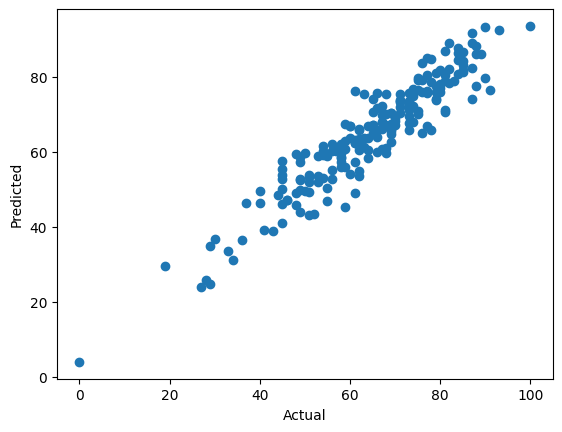

In [88]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='math_score'>

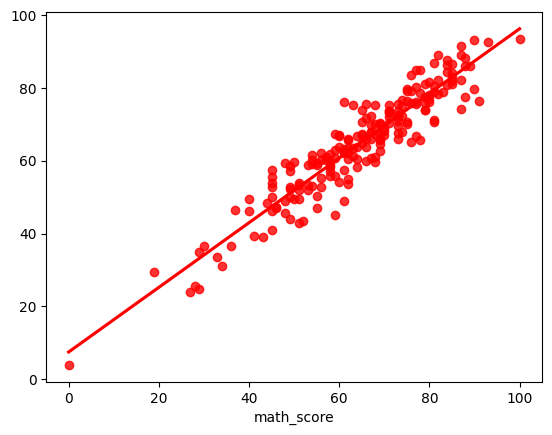

In [89]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')

# Difference between Actual and Predicted Values

In [90]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
print(pred_df)

     Actual Value  Predicted Value  Difference
521            91        76.398705   14.601295
737            53        58.842469   -5.842469
740            80        76.992129    3.007871
660            74        76.805898   -2.805898
411            84        87.615387   -3.615387
..            ...              ...         ...
408            52        43.492293    8.507707
332            62        62.170763   -0.170763
208            74        67.910325    6.089675
613            65        67.061504   -2.061504
78             61        62.427189   -1.427189

[200 rows x 3 columns]


# CatBoost Model

In [91]:
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

cat_cols = cat_features.tolist()
for c in cat_cols:
    X_train_cb[c] = X_train_cb[c].astype("string").fillna("missing")
    X_test_cb[c] = X_test_cb[c].astype("string").fillna("missing")

cb = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.05,
    depth=6,
    loss_function="RMSE",
    random_seed=42,
    early_stopping_rounds=100,
    verbose=200,
    allow_writing_files=False,
)

cb.fit(X_train_cb, y_train, cat_features=cat_cols, eval_set=(X_test_cb, y_test))

y_test_pred = cb.predict(X_test_cb)
mae, rmse, r2 = evaluate_model(y_test, y_test_pred)
print(rmse, mae, r2)


0:	learn: 14.8529419	test: 15.5932360	best: 15.5932360 (0)	total: 1.75ms	remaining: 5.25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 14.33963756
bestIteration = 83

Shrink model to first 84 iterations.
14.339637561586159 11.42114426595597 0.15498250420955917
